### Linear Regression Implementation from Scratch

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import random

## Generating the Dataset

To keep things simple, we will construct an artificial dataset
according to a linear model with additive noise.

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.6664, 0.1467]) 
label: tensor([7.0340])


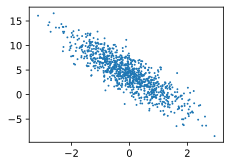

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1)

## Reading the Dataset

In the following code, we define the `data_iter` function
to demonstrate one possible implementation of this functionality.
The function takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`.
Each minibatch consists of a tuple of features and labels.

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.4970,  1.0890],
        [-1.1842, -0.5975],
        [-0.0147, -0.4493],
        [-2.5633,  0.6845],
        [-0.2983, -0.6728],
        [ 1.8324, -1.3458],
        [-1.5287, -0.3540],
        [-0.5416, -1.2462],
        [ 0.2167, -1.1531],
        [ 1.6533, -0.0156]]) 
 tensor([[ 5.4901],
        [ 3.8777],
        [ 5.7066],
        [-3.2584],
        [ 5.8908],
        [12.4298],
        [ 2.3496],
        [ 7.3567],
        [ 8.5318],
        [ 7.5814]])


## Initializing Model Parameters

Before we can begin optimizing our model's parameters by minibatch stochastic gradient descent,
we need to have some parameters in the first place.
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0.

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## Defining the Model

Next, we must define our model,
relating its inputs and parameters to its outputs.
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.

In [9]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Loss Function

Since updating our model requires taking
the gradient of our loss function,
we ought to define the loss function first.
Here we will use the squared loss function
as described in :numref:`sec_linear_regression`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.

In [10]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.
The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.

In [11]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039647
epoch 2, loss 0.000161
epoch 3, loss 0.000054


Thus, we can evaluate our success in training
by comparing the true parameters
with those that we learned through our training loop.
Indeed they turn out to be very close to each other.

In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0009, -0.0007], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0006], grad_fn=<RsubBackward1>)
